In [173]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
from PIL import ImageEnhance
from PIL import Image, ImageFilter
import os
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc as misc
import cv2
img_path = "./img/b.jpg"
color_path = "./img/img_001.jpg"
print(os.path.exists(img_path))

True


In [174]:
img = matplotlib.image.imread(img_path)
color_img = matplotlib.image.imread(color_path)

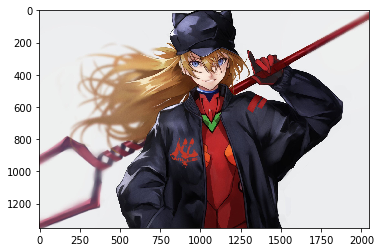

In [175]:
plt.imshow(img)

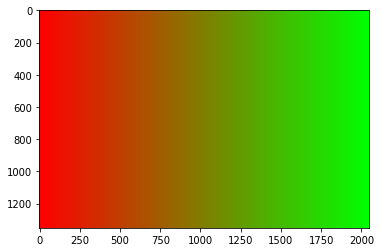

In [176]:
plt.imshow(color_img)

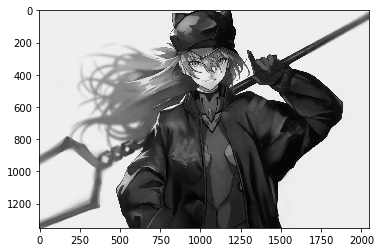

In [177]:
# 平均值灰度化
img_gray = img.mean(axis=-1)
plt.imshow(img_gray, cmap="gray")

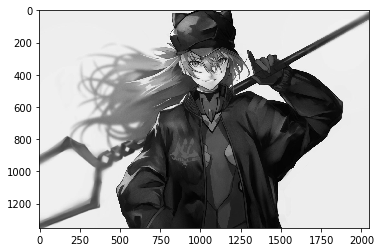

In [178]:
w = [0.299, 0.587, 0.114]
img_gray = np.dot(img, w)
plt.imshow(img_gray, cmap="gray")

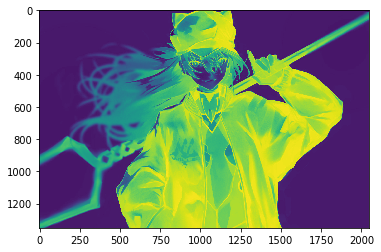

In [179]:
# 反色
img_oppsite = 255 - img_gray
plt.imshow(img_oppsite)

In [180]:
import scipy.signal as signal
height = img.shape[0]
width = img.shape[1]

In [181]:
# 二维中值滤波
img_min = signal.medfilt2d(np.array(img_oppsite), kernel_size=3)  

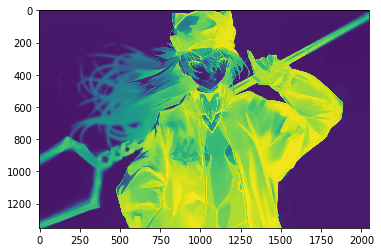

In [182]:
plt.imshow(img_min)

In [183]:
# 最小值滤波
def max_box(image):
    mean_image = np.zeros(shape=image.shape, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
#             for k in range(image.shape[2]):
#                 mean_image[i][j][k] = np.min(image[i:i+3,j:j+3,k])
            mean_image[i][j] = np.min(image[i:i+3,j:j+3])
    return mean_image

In [184]:
img_min = max_box(img_oppsite)

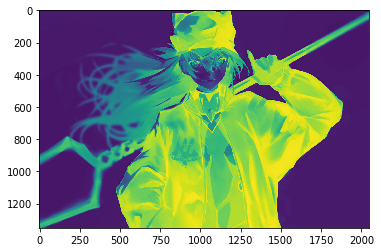

In [185]:
plt.imshow(img_min)

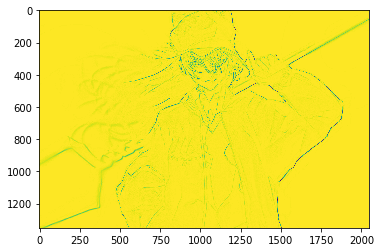

In [186]:
img_result = img_min + img_gray
plt.imshow(img_result)

In [187]:
for i in range(height):
    for j in range(width):
        if img_result[i, j]< 255*0.95:
            img_result[i, j] = img_result[i, j] * 0.39

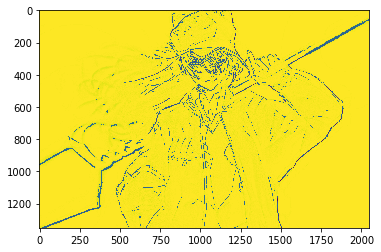

In [188]:
plt.imshow(img_result)

In [189]:
# reshape 成 3 维并重复最后 1 维
img_result2 = img_result.reshape((height, width, 1)).repeat(3, axis=-1)
img_result2.shape

(1351, 2048, 3)

<class 'numpy.ndarray'> (1351, 2048, 3)


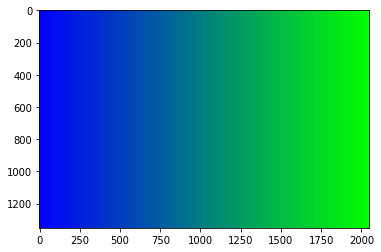

In [190]:
# 准备color file
im = cv2.imread(color_path)
print(type(im), im.shape)
color_img = cv2.resize(im, (width, height), interpolation=cv2.INTER_LINEAR)

plt.imshow(color_img)

In [191]:
image_final = color_img*1.1 + img_result2*0.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


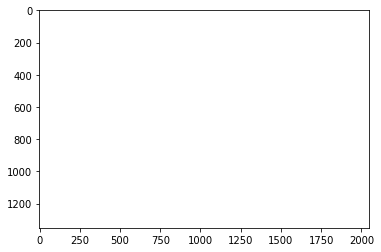

In [192]:
plt.imshow(image_final)

In [193]:
def GaussianFilter(img):
    # 高斯滤波 k = 3, sigma = 1
    h,w,c = img.shape
    K_size = 3
    sigma = 1
    
    # 零填充
    pad = K_size//2
    out = np.zeros((h + 2*pad,w + 2*pad,c),dtype=np.float)
    out[pad:pad+h,pad:pad+w] = img.copy().astype(np.float)
    
    # 定义滤波核
    K = np.zeros((K_size,K_size),dtype=np.float)
    
    for x in range(-pad,-pad+K_size):
        for y in range(-pad,-pad+K_size):
            K[y+pad,x+pad] = np.exp(-(x**2+y**2)/(2*(sigma**2)))
    K /= (sigma*np.sqrt(2*np.pi))
    K /=  K.sum()
    
    # 卷积的过程
    tmp = out.copy()
    for y in range(h):
        for x in range(w):
            for ci in range(c):
                out[pad+y,pad+x,ci] = np.sum(K*tmp[y:y+K_size,x:x+K_size,ci])
    
    out = out[pad:pad+h,pad:pad+w].astype(np.uint8)
    
    return out

In [194]:
im = GaussianFilter(image_final)

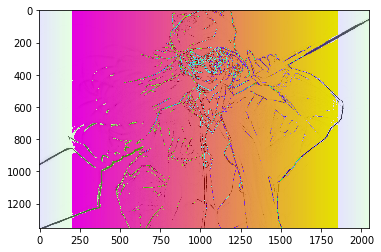

In [195]:
plt.imshow(im)

In [200]:
image = PIL.Image.fromarray(im)

In [201]:
image.save("./img/asda.jpg")

In [172]:
# 生成渐变色
import numpy as np
from PIL import Image


def RGB(r,g,b): return (r,g,b)

def Make_img_data(width, height, rgb):
    '''Make image data'''
    result = np.zeros((height, width, 3), dtype=np.uint8)
    for i, v in enumerate(rgb):
        result[:,:,i] = np.tile(np.linspace(v, v, width), (height, 1))
    
    return result

def Make_gradation_img_data(width, height, rgb_start, rgb_stop, horizontal=(True, True, True)):
    '''Make gradation image data'''
    result = np.zeros((height, width, 3), dtype=np.uint8)
    for i, (m,n,o) in enumerate(zip(rgb_start, rgb_stop, horizontal)):
        if o:
            result[:,:,i] = np.tile(np.linspace(m, n, width), (height, 1))
        else:
            result[:,:,i] = np.tile(np.linspace(m, n, width), (height, 1)).T
    
    return result

MakeImg = lambda width, height, rgb: Image.fromarray(Make_img_data(width, height, rgb))

MakeGradationImg = lambda width, height, rgb_start, rgb_stop, horizontal=(True, True, True): \
    Image.fromarray(Make_gradation_img_data(width, height, rgb_start, rgb_stop, horizontal))


# #Function Test
# img = MakeImg(400, 400, RGB(255,0,0))   #red
# img.save('red.png')
# #~ img.show()

# img = MakeImg(400, 400, RGB(0,255,0))   #green
# img.save('green.png')
# #~ img.show()

# img = MakeImg(400, 400, RGB(0,0,255))   #blue
# img.save('blue.png')
# #~ img.show()

img = MakeGradationImg(width, height, RGB(255,0,0), RGB(0,255,0), (True, True, True))
img.save('./img/img_001.jpg')
#~ img.show()

# img = MakeGradationImg(400, 400, RGB(255,0,0), RGB(0,255,0), (False, True, True))
# img.save('./img/img_002.png')
# #~ img.show()

# img = MakeGradationImg(400, 400, RGB(255,0,0), RGB(0,255,0), (False, False, True))
# img.save('./img/img_003.png')
# #~ img.show()

# img = MakeGradationImg(400, 400, RGB(255,0,0), RGB(0,255,0), (False, False, False))
# img.save('./img/img_004.png')
# #~ img.show()

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# 创建一个500*500的矩阵
input_images = np.zeros((500, 500))

# convert将当前图像转换为灰度模式，并且返回新的图像。
# 将图片在重新定义的矩阵中再显示，不然可能会只显示部分。
img = Image.open(img_path).resize((500, 500)).convert('L')
plt.subplot(221)
plt.title('原图')
plt.imshow(img)
# 图像的尺寸，按照像素数计算。它的返回值为宽度和高度的二元组（width, height）。
width = img.size[0]
height = img.size[1]
threshold = 130
# 可以改写代码使其成为二值化,此代码可理解为反向二值化
for h in range(height):
    for w in range(width):
        # getpixel直接获得（h，w）处的像素直接返回这个点三个通道的像素值
        # 返回给定位置的像素值。如果图像为多通道，则返回一个元组(r,g,b,阈值）。
        # 如果改成（w，h）出现的图像会倒转
        if img.getpixel((w, h)) < threshold:

            input_images[h, w] = 1
        else:
            input_images[h, w] = 0
plt.subplot(222)
plt.title('二值化')
plt.imshow(input_images)

data = signal.medfilt2d(np.array(img), kernel_size=3)  # 二维中值滤波
for h in range(0, height):
    for w in range(0, width):
        if data[h][w] < 128:
            input_images[h, w] = 0
        else:
            input_images[h, w] = 1

plt.subplot(223)
plt.title('中值滤波去噪（3*3）')
plt.imshow(input_images)

data = signal.medfilt2d(np.array(img), kernel_size=7)  # 二维中值滤波
for h in range(0, height):
    for w in range(0, width):
        if data[h][w] < 128:
            input_images[h, w] = 0
        else:
            input_images[h, w] = 1
plt.subplot(224)
plt.title('中值滤波去噪（7*7）')
plt.imshow(input_images)
plt.show()